#### Import


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

##### Тут мы загрузим и посмотрим на датасет.

In [3]:
DATA_PATH_TRAIN = "mai-ml-contest-1-2025-1/train.csv"
df = pd.read_csv(DATA_PATH_TRAIN)
DATA_PATH_TEST = "mai-ml-contest-1-2025-1/test.csv"
test = pd.read_csv(DATA_PATH_TEST)
df.head()

,ApplicationDate,Age,AnnualIncome,CreditScore,LoanAmount,LoanDuration,MaritalStatus,NumberOfDependents,HomeOwnershipStatus,MonthlyDebtPayments,...,EmploymentStatus,EducationLevel,Experience,NetWorth,BaseInterestRate,InterestRate,MonthlyLoanPayment,TotalDebtToIncomeRatio,LoanApproved,RiskScore
0,2010-06-26,27.0,66829.0,549.0,17290.0,60.0,Divorced,1.0,Rent,1095.0,...,Employed,Associate,4.0,35067.0,0.257790,0.251465,508.970230,0.288013,0.0,66.176500
1,1996-09-23,55.0,172147.0,850.0,16110.0,36.0,Widowed,1.0,Mortgage,211.0,...,Employed,High School,33.0,27001.0,0.086110,0.093173,514.675859,0.050585,1.0,28.495737
2,2015-01-19,51.0,300000.0,850.0,38436.0,36.0,Married,0.0,Mortgage,546.0,...,Employed,Bachelor,28.0,278382.0,0.108436,0.115443,1268.276385,0.072571,1.0,34.488104
3,1981-05-12,25.0,34683.0,847.0,19186.0,48.0,Married,0.0,Other,153.0,...,Employed,High School,0.0,9224.0,0.100686,0.112822,498.505187,0.225415,1.0,36.910753
4,1995-05-07,55.0,300000.0,850.0,30437.0,48.0,Single,2.0,Rent,562.0,...,Employed,Bachelor,31.0,4502.0,0.110437,0.089037,756.035156,0.052721,1.0,31.347091


##### Ящики с усами для удаления выбросов.

С их помощью мы определим выбросы в данных. Да и вообще в целом оценим распределение.

Plotting box plot for: Age
Plotting box plot for: AnnualIncome
Plotting box plot for: CreditScore
Plotting box plot for: LoanAmount
Plotting box plot for: LoanDuration
Plotting box plot for: NumberOfDependents
Plotting box plot for: MonthlyDebtPayments
Plotting box plot for: CreditCardUtilizationRate
Plotting box plot for: NumberOfOpenCreditLines
Plotting box plot for: NumberOfCreditInquiries
Plotting box plot for: DebtToIncomeRatio
Plotting box plot for: BankruptcyHistory
Plotting box plot for: PreviousLoanDefaults
Plotting box plot for: PaymentHistory
Plotting box plot for: LengthOfCreditHistory
Plotting box plot for: SavingsAccountBalance
Plotting box plot for: CheckingAccountBalance
Plotting box plot for: TotalAssets
Plotting box plot for: TotalLiabilities
Plotting box plot for: MonthlyIncome
Plotting box plot for: UtilityBillsPaymentHistory
Plotting box plot for: JobTenure
Plotting box plot for: Experience
Plotting box plot for: NetWorth
Plotting box plot for: BaseInterestRate
Plo

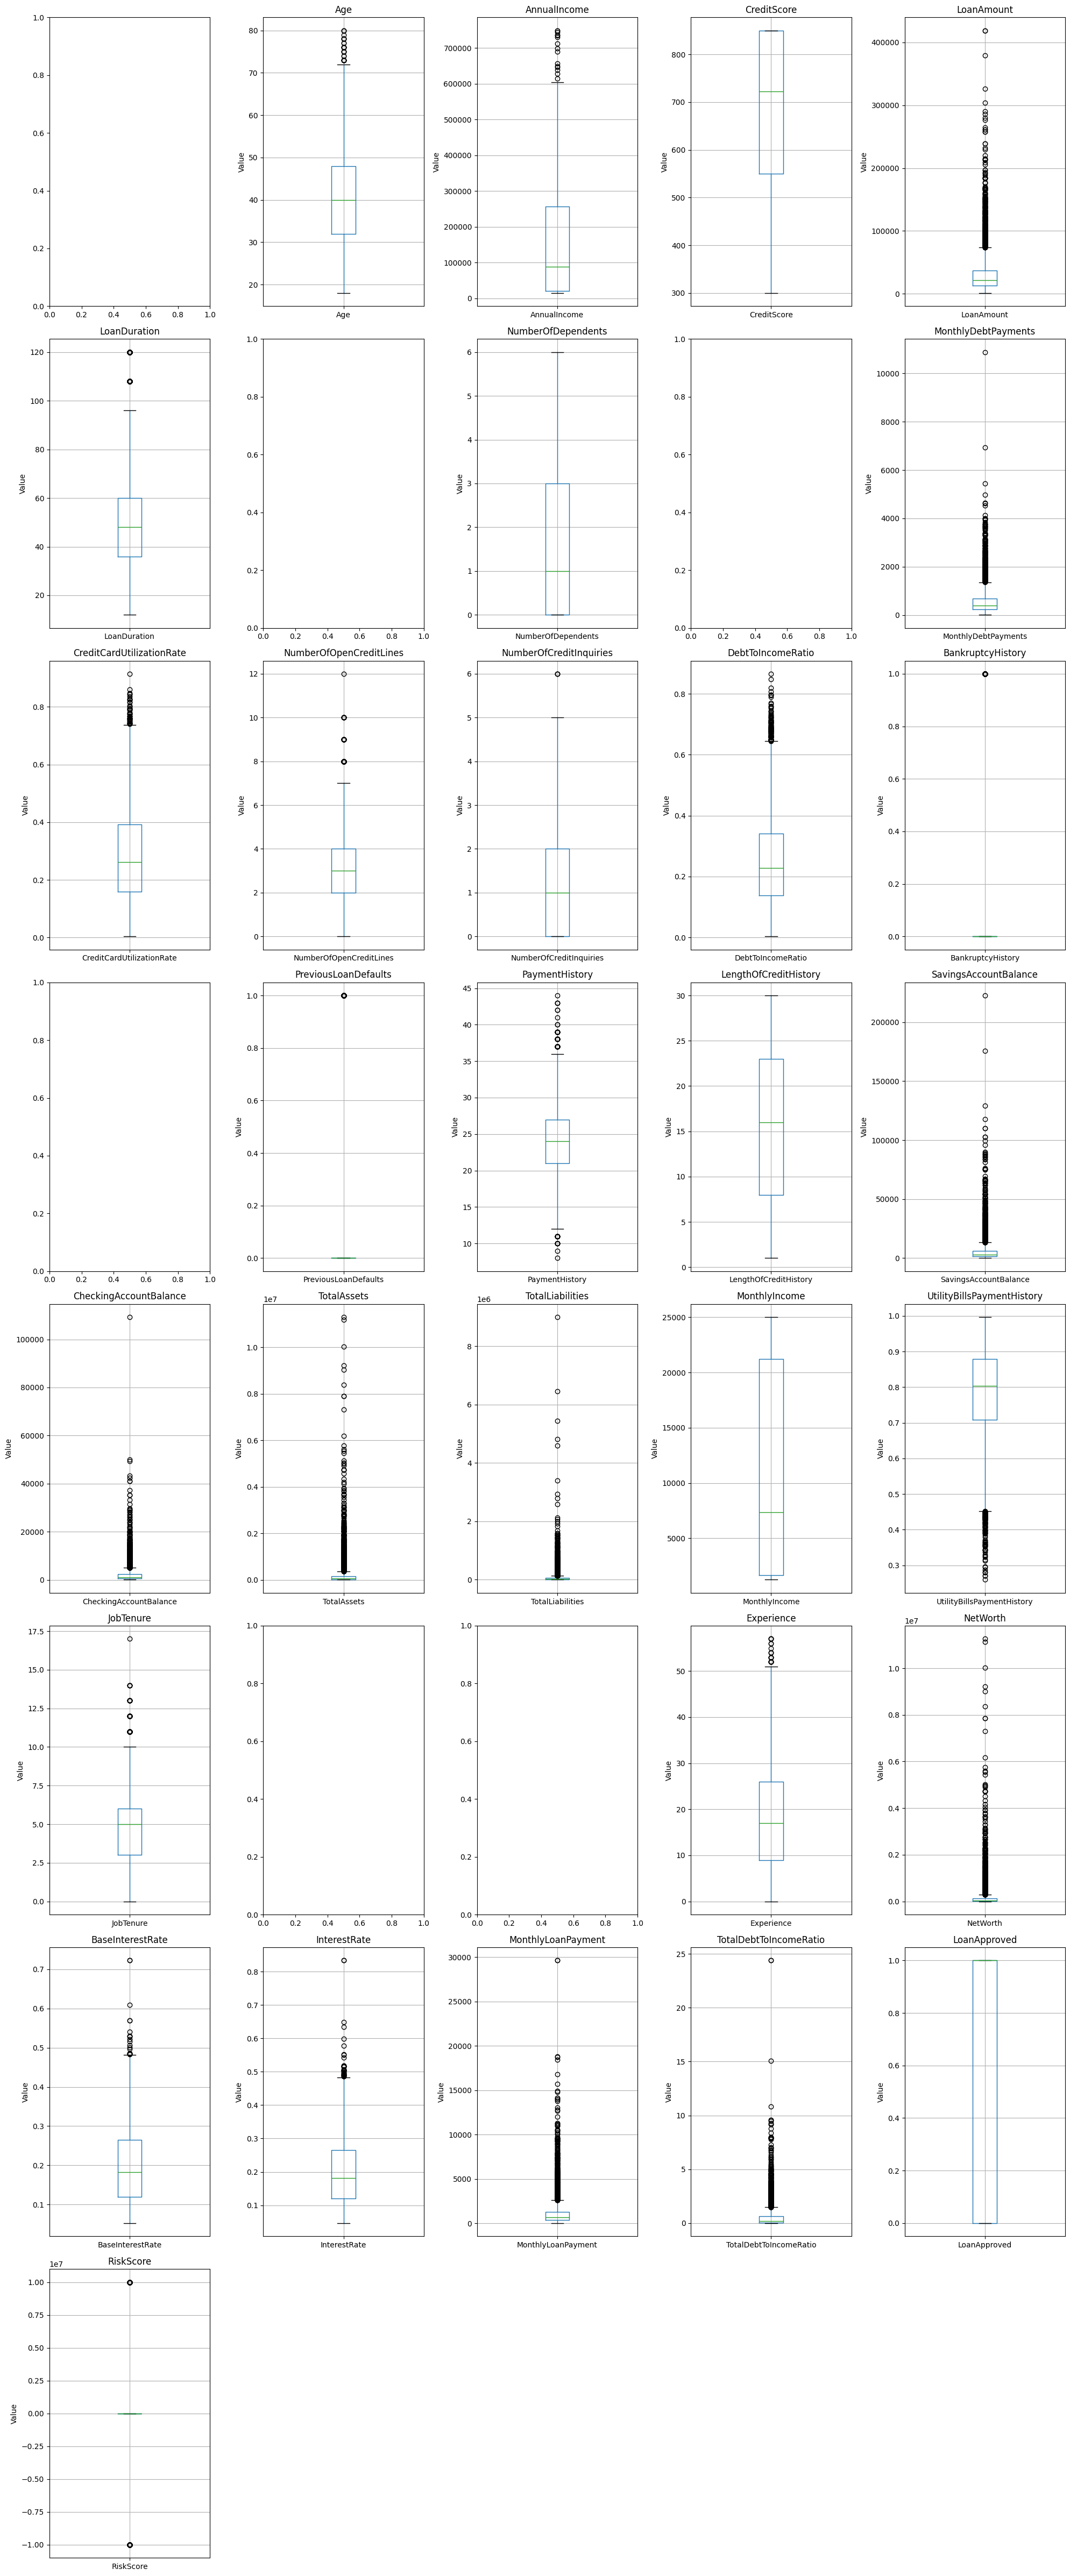

In [4]:
num_columns = len(df.columns)
nrows = 8

fig, axes = plt.subplots(nrows=nrows, ncols=5, figsize=(20, 6*nrows))
axes = axes.ravel()

for i, col in enumerate(df.columns):
    if pd.api.types.is_numeric_dtype(df[col]):
        print(f'Plotting box plot for: {col}')
        try:
            df.boxplot(column=col, ax=axes[i])
            axes[i].set_title(col)
            axes[i].set_ylabel('Value')
        except Exception as e:
            print(f'Error plotting {col}: {e}')  # Для отладки

# Удаление пустых осей, если количество признаков меньше, чем оси
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

##### Пропущенные данные

Обнаруживаем пропуски в данных, замечаем определенную закономерность.

<Axes: >

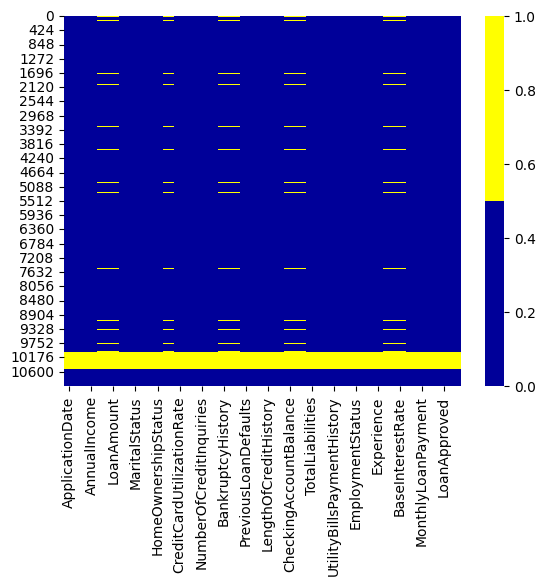

In [5]:
cols = df.columns
colours = ['#000099', '#ffff00'] 
sns.heatmap(df[cols].isnull(), cmap=sns.color_palette(colours))

##### Нормализация и трансформация данных.

Тут я пишу всякие нормализаторы и трансфоматоры, которые в процессе буду использовать на данных.

In [6]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

###### Логарифмический нормализатор.
Необходим для нормализации данных с экспоненциальным распределением. И для данных со смещенным нормальный распределением.

In [7]:
class LogTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return pd.DataFrame(np.log1p(X))

###### One-hot encoder трансформатор.

In [8]:
class GetDummiesTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        dummies = pd.get_dummies(X[self.columns], drop_first=True)
        X = pd.concat([X.drop(columns=self.columns), dummies], axis=1)
        return X

###### Удаление целевой переменной.

In [9]:
class DropTargetColumn(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if isinstance(X, pd.DataFrame):
            return X.drop(columns=[self.X])
        else:
            raise ValueError("Input should be a pandas DataFrame")

###### Разбор даты в данных.

In [10]:
class DateProcessor(BaseEstimator, TransformerMixin):
    def __init__(self, date_column):
        self.date_column = date_column

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X[self.date_column] = pd.to_datetime(X[self.date_column], format='%Y-%m-%d')
        X['application_year'] = X[self.date_column].dt.year
        X['application_month'] = X[self.date_column].dt.month
        X['application_day_of_week'] = X[self.date_column].dt.dayofweek
        
        X = X.drop(self.date_column, axis=1)
        
        return X

###### Преобразование булевых столбцов в числовые.

In [11]:
class BoolToIntTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns

    def fit(self, X, y=None):
        if self.columns is None:
            self.columns = X.select_dtypes(include=[bool]).columns.tolist()
        return self

    def transform(self, X):
        X = X.copy()

        bool_columns = []
        if self.columns is None:
            bool_columns = X.select_dtypes(include=[bool]).columns
        else:
            bool_columns = [col for col in self.columns if col in X.columns and X[col].dtype == 'bool']
            missing_columns = [col for col in self.columns if col not in X.columns]
            if missing_columns:
                print(f"Warning: The following columns do not exist in the DataFrame and will be ignored: {missing_columns}")
        X[bool_columns] = X[bool_columns].astype(int)
        return pd.DataFrame(X)

###### Удаление определенных столбцов.

In [12]:
class DropColumnsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_drop=None):
        self.columns_to_drop = columns_to_drop

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        return X.drop(columns=self.columns_to_drop, errors='ignore')

###### Удаление выбросов за пределами определенных квантилей.

In [13]:
class IQRDropoutTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None, multiplier=1.5):
        self.columns = columns
        self.multiplier = multiplier

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        
        if self.columns is None:
            columns = X.select_dtypes(include=[np.number]).columns
        else:
            columns = self.columns
        
        for column in columns:
            if column in X.columns:

                Q1 = X[column].quantile(0.25)
                Q3 = X[column].quantile(0.75)
                IQR = Q3 - Q1

                lower_bound = Q1 - self.multiplier * IQR
                upper_bound = Q3 + self.multiplier * IQR

                X = X[(X[column] >= lower_bound) & (X[column] <= upper_bound)]
        
        return X

###### Удаление дубликатов и пропусков. 

In [14]:
class DropDuplicatesAndNaNTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
        X = X.copy()
        X = X.drop_duplicates()
        X = X.dropna()
        return pd.DataFrame(X) 

###### Удаление данных со странным RiskScore'ом.

In [15]:
class RiskScoreFilter(BaseEstimator, TransformerMixin):
    def __init__(self, column='RiskScore', min_value=-10000, max_value=10000):
        self.column = column
        self.min_value = min_value
        self.max_value = max_value

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X = X[(X[self.column] >= self.min_value) & (X[self.column] <= self.max_value)]
        return pd.DataFrame(X)

#### mylinreg и тестим её

In [24]:
from sklearn.base import RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted

class MyLinearRegression(BaseEstimator, RegressorMixin):
    def __init__(self, method='analytic', learning_rate=0.01, n_iters=1000, batch_size=32, random_state=None):

        self.method = method
        self.learning_rate = learning_rate
        self.n_iters = n_iters
        self.batch_size = batch_size
        self.random_state = random_state
        
    def _add_bias(self, X):
        #Добавляет столбец единиц для intercept
        return np.c_[np.ones(X.shape[0]), X]
    
    def fit(self, X, y):
        X, y = check_X_y(X, y)
        X = self._add_bias(X)
        
        if self.method == 'analytic':
            self.coef_ = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
            
        elif self.method in ['gradient', 'stochastic']:
            np.random.seed(self.random_state)
            self.coef_ = np.random.randn(X.shape[1])
            
            for _ in range(self.n_iters):
                if self.method == 'stochastic':
                    idx = np.random.choice(X.shape[0], self.batch_size, replace=False)
                    X_batch = X[idx]
                    y_batch = y[idx]
                else:
                    X_batch = X
                    y_batch = y
                
                gradient = 2/X_batch.shape[0] * X_batch.T.dot(X_batch.dot(self.coef_) - y_batch)
                
                self.coef_ -= self.learning_rate * gradient
                
        else:
            raise ValueError("Метод должен быть 'analytic', 'gradient' или 'stochastic'")
        
        self.intercept_ = self.coef_[0]
        self.coef_ = self.coef_[1:]
        
        return self
    
    def predict(self, X):
        check_is_fitted(self, 'coef_')
        
        X = check_array(X)

        return self._add_bias(X).dot(np.r_[self.intercept_, self.coef_])

In [25]:

from sklearn.datasets import make_regression

# Создаем синтетические данные чтоб побыстрому чекнуть работу
X, y = make_regression(n_samples=1000, n_features=10, noise=0.1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

methods = {
    'Analytic': MyLinearRegression(method='analytic'),
    'Gradient': MyLinearRegression(method='gradient', learning_rate=0.01, n_iters=1000),
    'Stochastic': MyLinearRegression(method='stochastic', learning_rate=0.01, n_iters=1000, batch_size=32),
    'Sklearn': LinearRegression()
}

results = {}
for name, model in methods.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)
    results[name] = mse
    print(f"{name}: MSE = {mse:.6f}")
    if hasattr(model, 'coef_'):
        print(f"Коэффициенты: {model.coef_[:5]}...") 

Analytic: MSE = 0.009512
Коэффициенты: [34.30971289 32.29998402 29.72489615 77.86132977  7.19671954]...
Gradient: MSE = 0.009512
Коэффициенты: [34.30971191 32.29998302 29.72489523 77.86132875  7.19671991]...
Stochastic: MSE = 0.009519
Коэффициенты: [34.30954898 32.3007292  29.72634916 77.86180512  7.19587592]...
Sklearn: MSE = 0.009512
Коэффициенты: [34.30971289 32.29998402 29.72489615 77.86132977  7.19671954]...


### Все зачетно воркает без погрешностей мы молодцы

#### поехали к кросс-валидации

In [26]:
def kfold_cross_validation(model, X, y, k=5, random_state=42):
    kf = KFold(n_splits=k, shuffle=True, random_state=random_state)
    mse_scores = []
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        mse = mean_squared_error(y_test, y_pred)
        mse_scores.append(mse)
    
    return mse_scores

In [27]:
from sklearn.model_selection import LeaveOneOut

def loo_cross_validation(model, X, y):
    loo = LeaveOneOut()
    mse_scores = []
    
    for train_index, test_index in loo.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        mse = mean_squared_error(y_test, y_pred)
        mse_scores.append(mse)
    
    return mse_scores

#### чекнем работу

In [28]:
X, y = make_regression(n_samples=100, n_features=5, noise=0.1, random_state=42)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

model = LinearRegression()

kfold_scores = kfold_cross_validation(model, X_scaled, y, k=5)
print(f"K-Fold MSE: {np.mean(kfold_scores):.4f} ± {np.std(kfold_scores):.4f}")

loo_scores = loo_cross_validation(model, X_scaled, y)
print(f"LOO MSE: {np.mean(loo_scores):.4f} ± {np.std(loo_scores):.4f}")

K-Fold MSE: 0.0094 ± 0.0012
LOO MSE: 0.0098 ± 0.0145


Наш K-Fold время: 0.0206 сек
Sklearn K-Fold время: 0.0448 сек
Наш LOO время: 0.0780 сек
Sklearn LOO время: 0.1695 сек


/Users/admin/Desktop/MAI/Third/ml/.venv/lib/python3.9/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/admin/Desktop/MAI/Third/ml/.venv/lib/python3.9/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/admin/Desktop/MAI/Third/ml/.venv/lib/python3.9/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/admin/Desktop/MAI/Third/ml/.venv/lib/python3.9/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/admin/Desktop/MAI/Third/ml/.venv/lib/python3.9/site-packages/skle

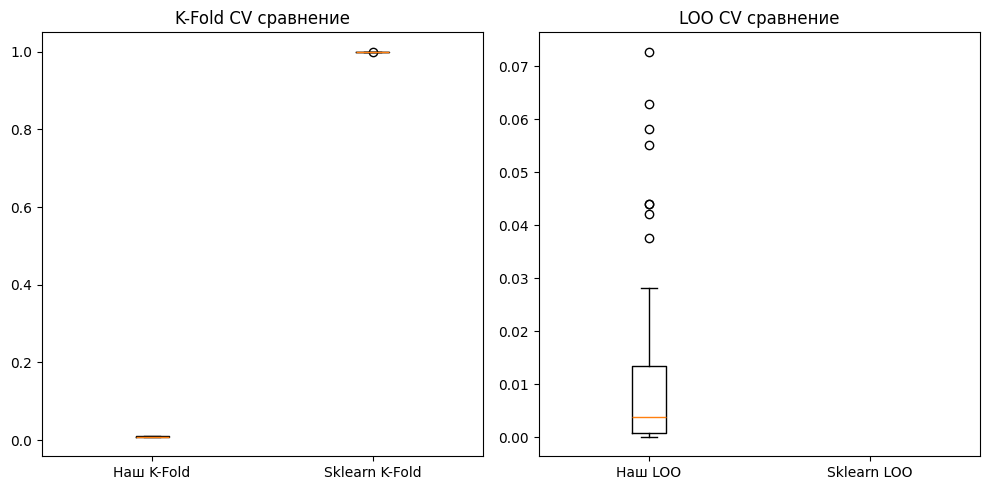

In [29]:
import time

start = time.time()
kfold_scores = kfold_cross_validation(model, X_scaled, y, k=5)
print(f"Наш K-Fold время: {time.time() - start:.4f} сек")

start = time.time()
kfold_scores_sklearn = cross_val_score(model, X_scaled, y, cv=5)
print(f"Sklearn K-Fold время: {time.time() - start:.4f} сек")

start = time.time()
loo_scores = loo_cross_validation(model, X_scaled, y)
print(f"Наш LOO время: {time.time() - start:.4f} сек")

start = time.time()
loo_scores_sklearn = cross_val_score(model, X_scaled, y, cv=LeaveOneOut())
print(f"Sklearn LOO время: {time.time() - start:.4f} сек")

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.boxplot([kfold_scores, kfold_scores_sklearn])
plt.xticks([1, 2], ['Наш K-Fold', 'Sklearn K-Fold'])
plt.title('K-Fold CV сравнение')

plt.subplot(1, 2, 2)
plt.boxplot([loo_scores, loo_scores_sklearn])
plt.xticks([1, 2], ['Наш LOO', 'Sklearn LOO'])
plt.title('LOO CV сравнение')

plt.tight_layout()
plt.show()

## Любимые метрики

In [31]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def mse(y_true, y_pred):
    """Mean Squared Error (MSE)"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean((y_true - y_pred) ** 2)

def mae(y_true, y_pred):
    """Mean Absolute Error (MAE)"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs(y_true - y_pred))

def r2(y_true, y_pred):
    """R-squared (R2)"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - (ss_res / ss_tot)

def mape(y_true, y_pred):
    """Mean Absolute Percentage Error (MAPE)"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0  # избегаем деления на ноль
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

### сразу тестим 

In [32]:
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

X, y = make_regression(n_samples=1000, n_features=10, noise=0.1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

metrics = {
    'MSE': (mse(y_test, y_pred), mean_squared_error(y_test, y_pred)),
    'MAE': (mae(y_test, y_pred), mean_absolute_error(y_test, y_pred)),
    'R2': (r2(y_test, y_pred), r2_score(y_test, y_pred)),
    'MAPE': (mape(y_test, y_pred), None)  # В sklearn нет прямой реализации MAPE
}

# Выводим результаты
print("{:<10} {:<15} {:<15} {:<10}".format('Metric', 'Our Impl', 'Sklearn', 'Diff'))
print("-" * 50)
for name, (our_val, sklearn_val) in metrics.items():
    if sklearn_val is not None:
        diff = abs(our_val - sklearn_val)
        print("{:<10} {:<15.6f} {:<15.6f} {:<10.2e}".format(name, our_val, sklearn_val, diff))
    else:
        print("{:<10} {:<15.6f} {:<15} {:<10}".format(name, our_val, 'N/A', 'N/A'))

Metric     Our Impl        Sklearn         Diff      
--------------------------------------------------
MSE        0.009512        0.009512        0.00e+00  
MAE        0.077733        0.077733        0.00e+00  
R2         0.999999        0.999999        0.00e+00  
MAPE       0.213552        N/A             N/A       


###### Выбор колонок, где что будем делать.

In [16]:
standart_columns = ['LoanDuration', 'PaymentHistory', 'JobTenure']

minimax_columns = ['NumberOfDependents', 'LengthOfCreditHistory', 'application_year', 'application_month', 'application_day_of_week']

log_columns = ['AnnualIncome', 'MonthlyDebtPayments', 'NumberOfCreditInquiries', 'SavingsAccountBalance', 'UtilityBillsPaymentHistory',
                  'CheckingAccountBalance', 'TotalLiabilities', 'NetWorth', 'CreditCardUtilizationRate', 'DebtToIncomeRatio', 'CreditScore', 'AnnualIncome',
                  'InterestRate', 'BaseInterestRate', 'TotalDebtToIncomeRatio', 'LoanAmount', 'Experience', 'MonthlyIncome', 'BaseInterestRate', 'InterestRate', 
                  'MonthlyLoanPayment', 'TotalAssets', 'AnnualIncome', 'NumberOfOpenCreditLines']

one_hot_features = ['MaritalStatus', 'HomeOwnershipStatus', 'EducationLevel', 'EmploymentStatus', 'LoanPurpose']

data_column = ['ApplicationDate']

target_column = ['RiskScore']

skip_features = []

###### Создание трансформеров и их применение.

Дополнительно тут применяется PCA -- метод главых компонент, которые выделяет важные столбцы. 

In [17]:
def filter_columns(columns, exclude):
    return [col for col in columns if col not in exclude]

preprocessor = ColumnTransformer(
    transformers=[
        ('log_and_scale', Pipeline([
            ('log', LogTransformer()),
            ('scaler', StandardScaler())
        ]), filter_columns(log_columns, skip_features)),
        ('standart', StandardScaler(), filter_columns(standart_columns, skip_features)),
        ('minimax', MinMaxScaler(), filter_columns(minimax_columns, skip_features)),
        ('pca', PCA(n_components=30), filter_columns(minimax_columns + standart_columns + log_columns, data_column + one_hot_features + target_column))
    ],
    remainder='passthrough'
)

###### Тестирование и обучение модели при помощи поиска по сетке.

In [18]:
models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(alpha = 0.1),
}

def test_models(X, y):
    alphas = np.linspace(0.1, 2, num=20) 

    param_grids = {
        'LinearRegression': {},
        'Ridge': {
            'classifier__alpha': alphas  # Правильно, указываем шаг пайплайна
        },
    }   

    for model_name, model in models.items():
        print(f"Тестирование модели: {model_name}")

        pipeline = Pipeline([
            ('classifier', model)
        ])

        grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grids[model_name], cv=5, scoring='neg_mean_squared_error')
        
        grid_search.fit(X, y)
        
        print("Лучшие параметры:", grid_search.best_params_)
        print("Лучшая MSE:", -grid_search.best_score_)
        print()

In [19]:
def preprocess_data(X, transformers):
    X = X.copy()
    for transformer in transformers:
        X = transformer.transform(X)
    return X

# Применение функции с указанием трансформеров
transformers = [
    DropDuplicatesAndNaNTransformer(),
    DateProcessor(data_column[0]),
    GetDummiesTransformer(one_hot_features),
    RiskScoreFilter('RiskScore', min_value=-10000, max_value=10000),
    BoolToIntTransformer(df.columns)
]

df_cleaned = preprocess_data(df, transformers)

Y = df_cleaned['RiskScore']
df_cleaned = df_cleaned.drop('RiskScore', axis=1)

X_proc = preprocessor.fit_transform(df_cleaned)

test_models(X_proc, Y)

Тестирование модели: LinearRegression
Лучшие параметры: {}
Лучшая MSE: 12.668006348329358

Тестирование модели: Ridge


/Users/admin/Desktop/MAI/Third/ml/.venv/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=2.72852e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/admin/Desktop/MAI/Third/ml/.venv/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=2.65469e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/admin/Desktop/MAI/Third/ml/.venv/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=2.5103e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/admin/Desktop/MAI/Third/ml/.venv/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=2.66164e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos

Лучшие параметры: {'classifier__alpha': 0.1}
Лучшая MSE: 12.667895411131434



/Users/admin/Desktop/MAI/Third/ml/.venv/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=2.09019e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


###### Вывод матрицы корреляций.

На самом деле я хз почему, но если не дропать коррелирующие столбцы, то становится лучше. Поэтому так.

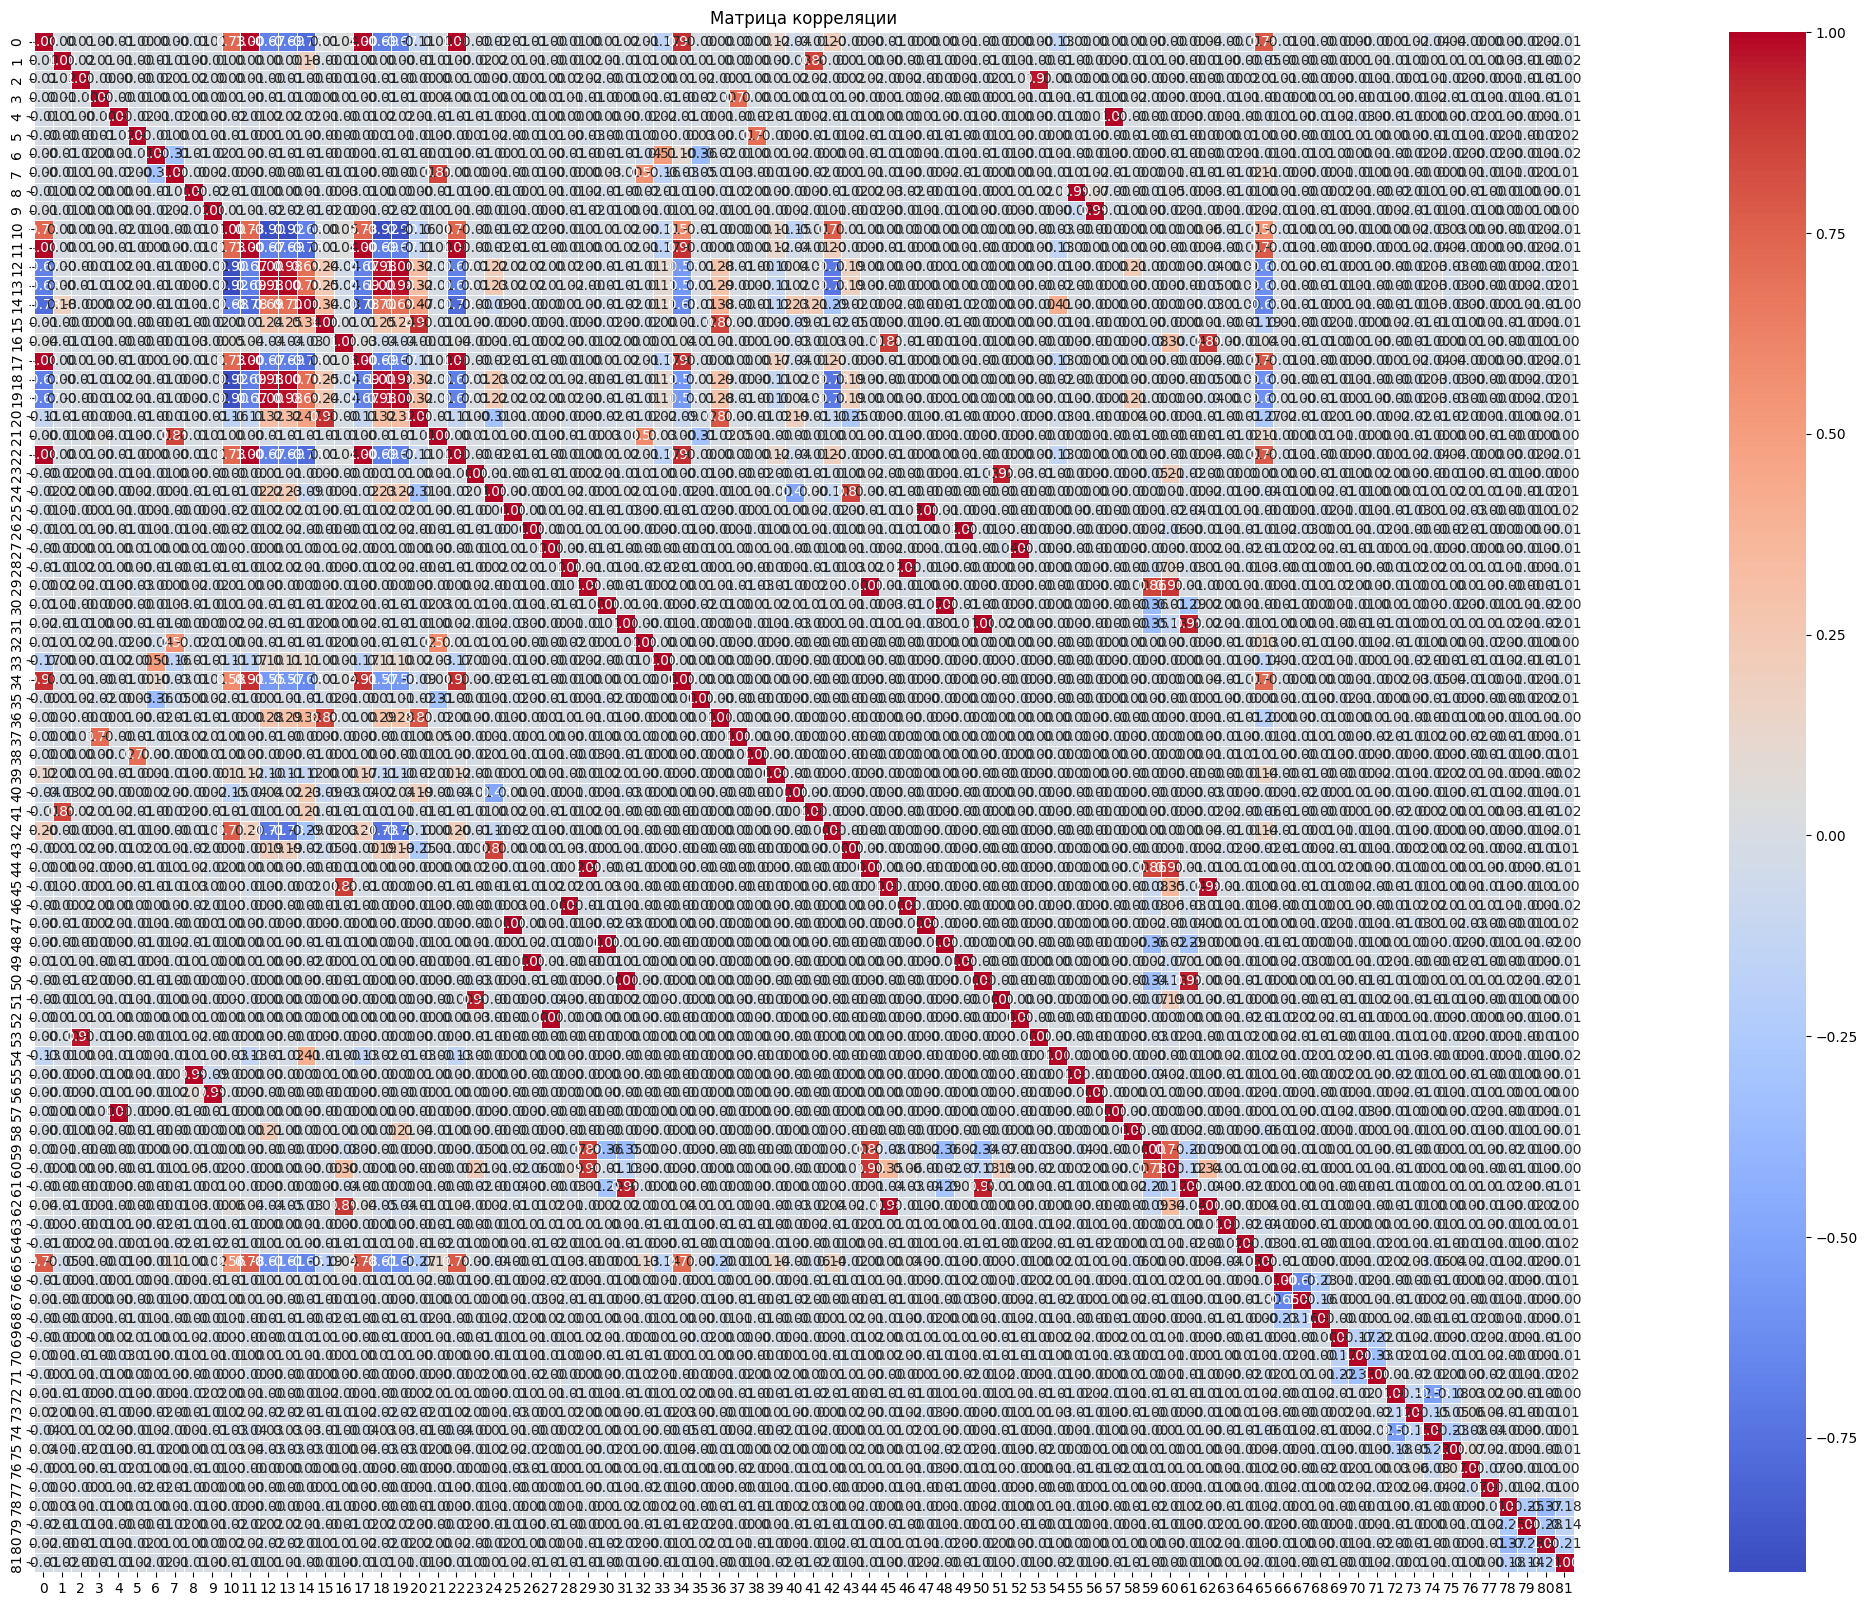

In [20]:
correlation_matrix = pd.DataFrame(X_proc).corr()
plt.figure(figsize=(40, 20))  # Установите размер графика
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', square=True, fmt='.2f', linewidths=.5)
plt.title('Матрица корреляции')
plt.show()

###### Вывод диаграмм для определение распределения.

/Users/admin/Desktop/MAI/Third/ml/.venv/lib/python3.9/site-packages/matplotlib/axes/_axes.py:7001: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  m, bins = np.histogram(x[i], bins, weights=w[i], **hist_kwargs)


Error plotting MaritalStatus_Married: numpy boolean subtract, the `-` operator, is not supported, use the bitwise_xor, the `^` operator, or the logical_xor function instead.
Error plotting MaritalStatus_Single: numpy boolean subtract, the `-` operator, is not supported, use the bitwise_xor, the `^` operator, or the logical_xor function instead.
Error plotting MaritalStatus_Widowed: numpy boolean subtract, the `-` operator, is not supported, use the bitwise_xor, the `^` operator, or the logical_xor function instead.
Error plotting HomeOwnershipStatus_Other: numpy boolean subtract, the `-` operator, is not supported, use the bitwise_xor, the `^` operator, or the logical_xor function instead.
Error plotting HomeOwnershipStatus_Own: numpy boolean subtract, the `-` operator, is not supported, use the bitwise_xor, the `^` operator, or the logical_xor function instead.
Error plotting HomeOwnershipStatus_Rent: numpy boolean subtract, the `-` operator, is not supported, use the bitwise_xor, the

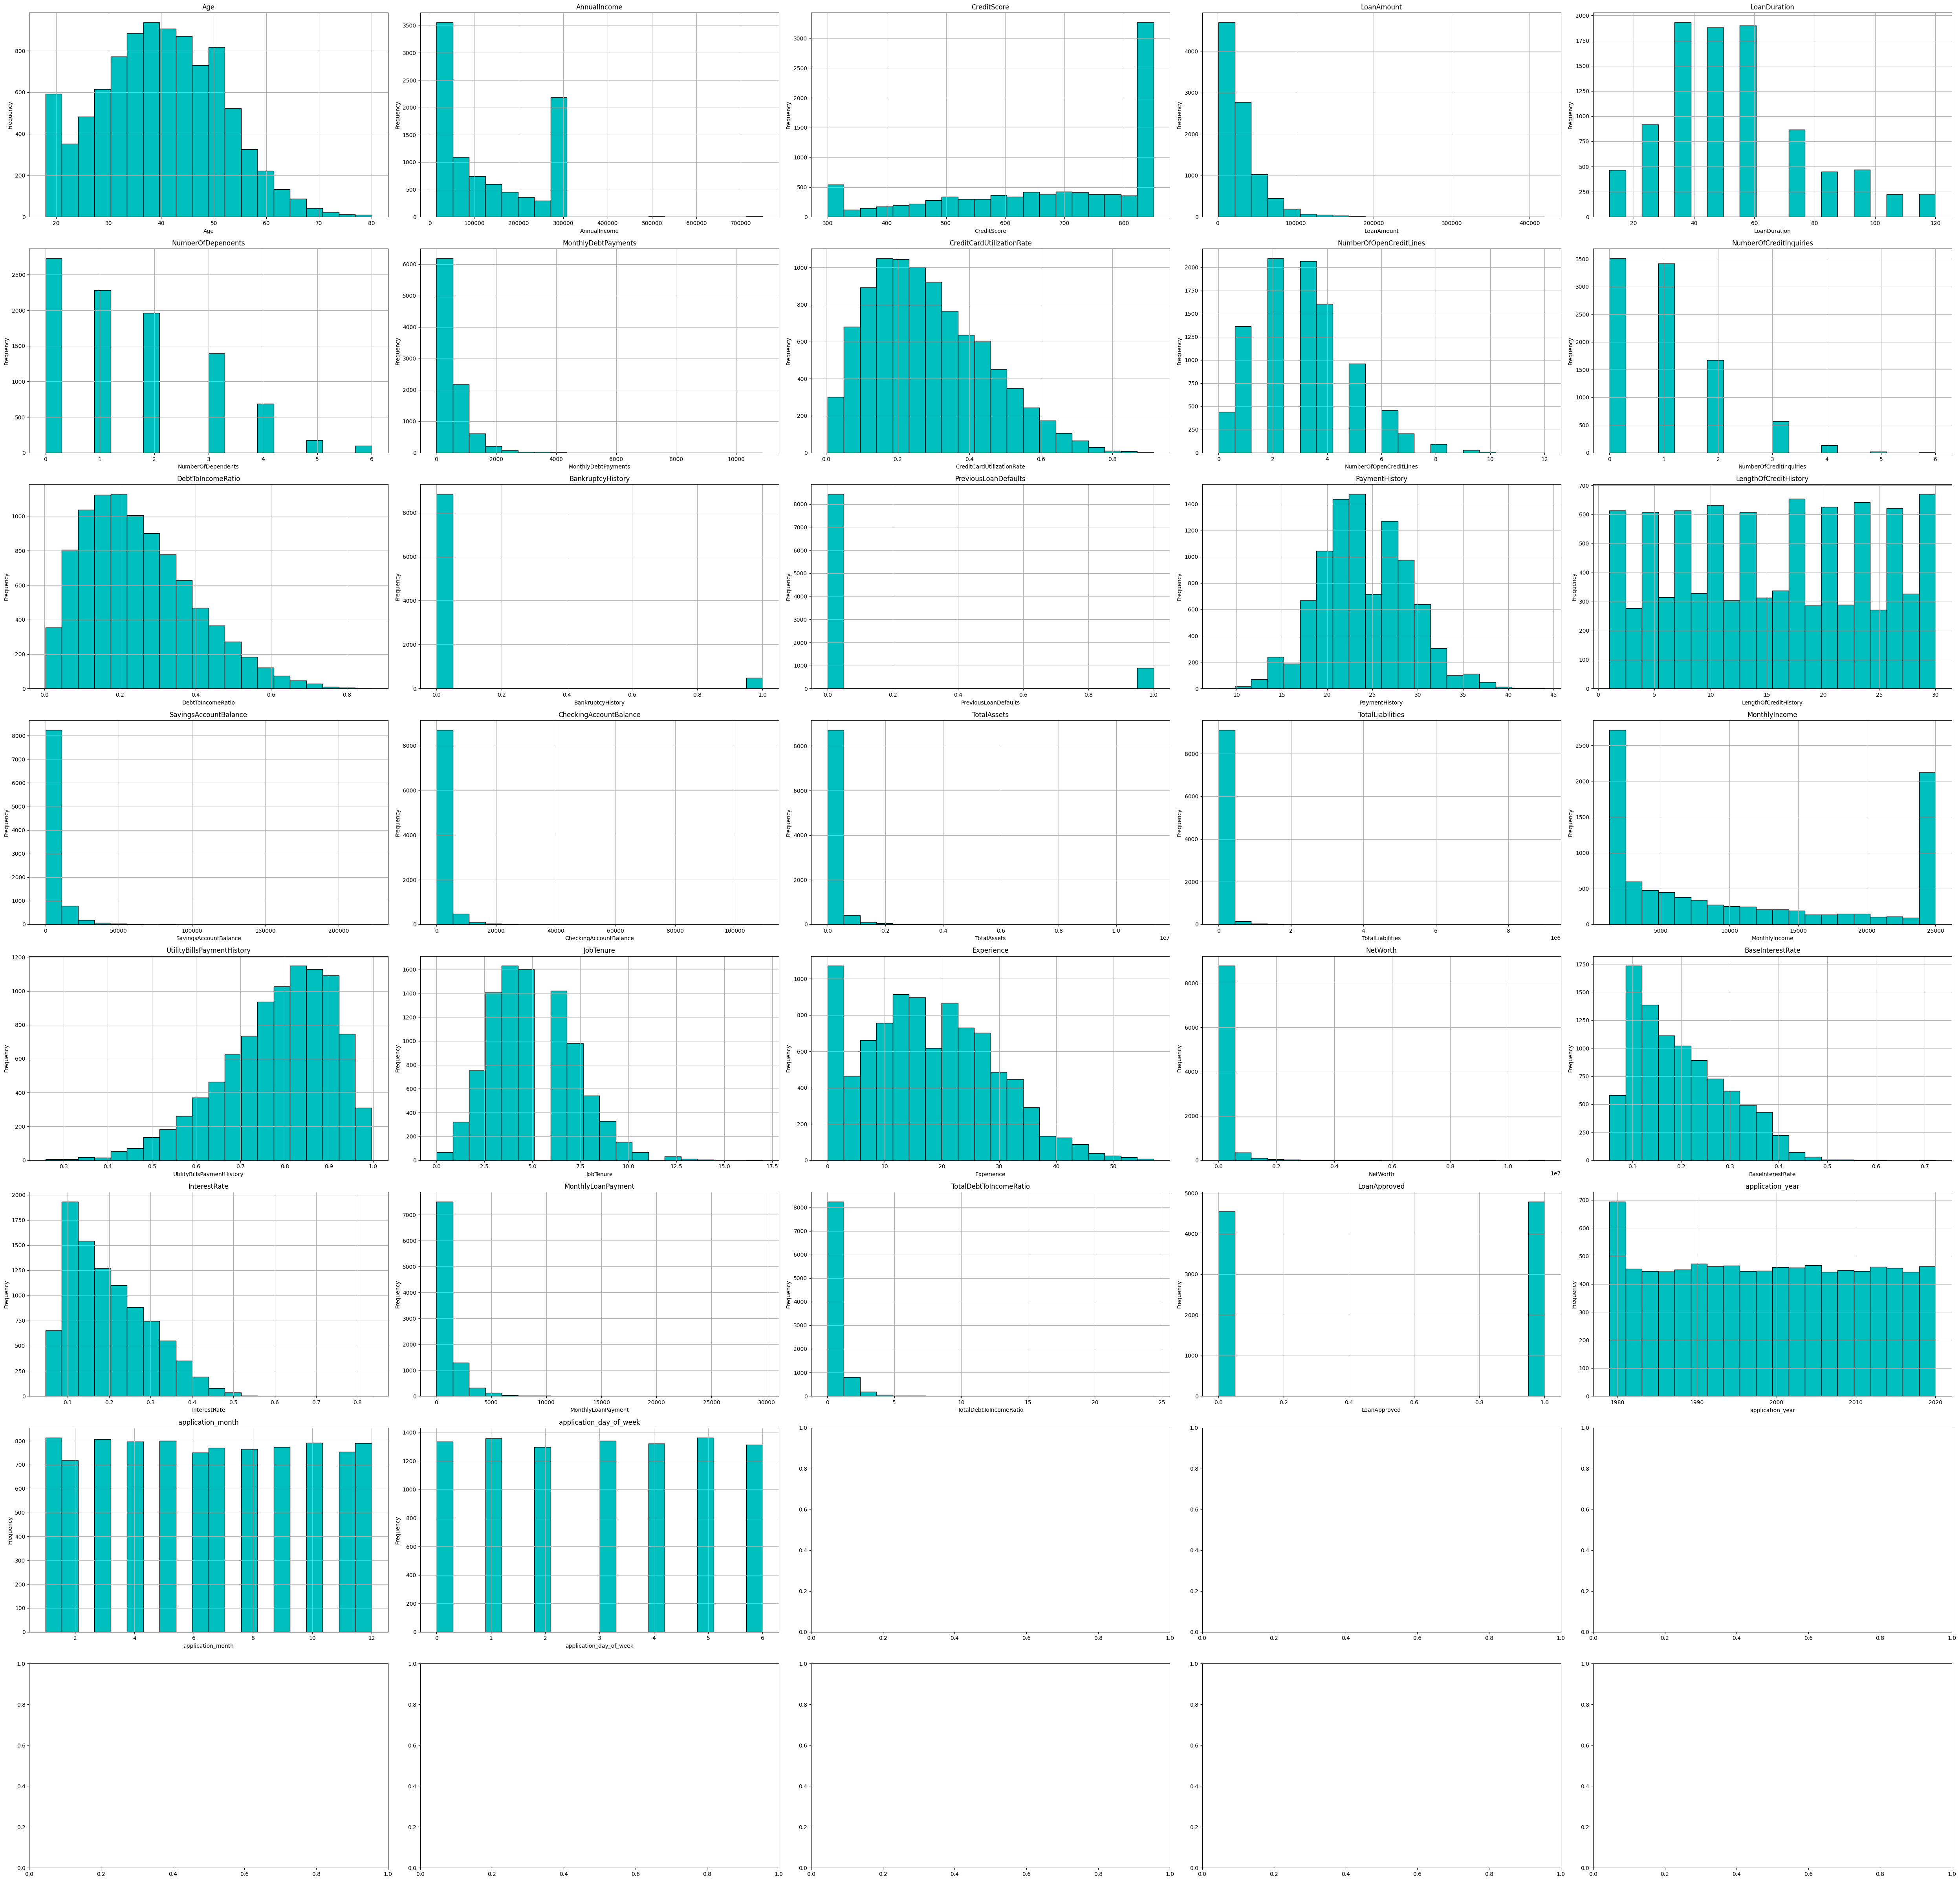

In [21]:
num_columns = len(df_cleaned.columns)

nrows = 8

fig, axes = plt.subplots(nrows=nrows, ncols=5, figsize=(50, 6*nrows))

axes = axes.ravel()

for i, col in enumerate(df_cleaned.columns):
    if pd.api.types.is_numeric_dtype(df_cleaned[col]):
        try:
            df_cleaned[col].hist(ax=axes[i], bins=20, color='c', edgecolor='black')
            axes[i].set_title(col)
            axes[i].set_xlabel(col)
            axes[i].set_ylabel('Frequency')
        except Exception as e:
            print(f'Error plotting {col}: {e}')  # Для отладки

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

###### Окончательное обучение модели и загрузка файлов в csv.

In [22]:
models['Ridge'].fit(X_proc, Y)

transformers_test = [
DropDuplicatesAndNaNTransformer(),
    DateProcessor(data_column[0]),
    GetDummiesTransformer(one_hot_features),
    # DropColumnsTransformer(corr_in_some_way),
    BoolToIntTransformer(df.columns),
]

df_test_clean = preprocess_data(test, transformers_test)
df_test_clean = df_test_clean.drop('ID', axis=1)
X_proc_test = preprocessor.transform(df_test_clean)

to_kaggle = models['Ridge'].predict(X_proc_test)
df_kaggle = pd.DataFrame({'ID': range(len(to_kaggle)), 'RiskScore': to_kaggle})
df_kaggle.to_csv('submission.csv', index=False)

/Users/admin/Desktop/MAI/Third/ml/.venv/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=2.09019e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


In [1]:
import numpy as np
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted

class MyLinearRegression(BaseEstimator, RegressorMixin):
    def __init__(self, method='analytic', learning_rate=0.01, n_iters=1000, batch_size=32, random_state=None):
        """
        Параметры:
        ----------
        method : str ('analytic', 'gradient', 'stochastic')
            Метод оптимизации
        learning_rate : float
            Скорость обучения для градиентных методов
        n_iters : int
            Количество итераций
        batch_size : int
            Размер батча для стохастического градиентного спуска
        random_state : int
            Для воспроизводимости
        """
        self.method = method
        self.learning_rate = learning_rate
        self.n_iters = n_iters
        self.batch_size = batch_size
        self.random_state = random_state
        
    def _add_bias(self, X):
        """Добавляет столбец единиц для intercept"""
        return np.c_[np.ones(X.shape[0]), X]
    
    def fit(self, X, y):
        # Проверка входных данных
        X, y = check_X_y(X, y)
        X = self._add_bias(X)
        
        if self.method == 'analytic':
            # Аналитическое решение (нормальное уравнение)
            self.coef_ = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
            
        elif self.method in ['gradient', 'stochastic']:
            # Инициализация весов
            np.random.seed(self.random_state)
            self.coef_ = np.random.randn(X.shape[1])
            
            for _ in range(self.n_iters):
                if self.method == 'stochastic':
                    # Стохастический градиентный спуск
                    idx = np.random.choice(X.shape[0], self.batch_size, replace=False)
                    X_batch = X[idx]
                    y_batch = y[idx]
                else:
                    # Обычный градиентный спуск
                    X_batch = X
                    y_batch = y
                
                # Вычисление градиента
                gradient = 2/X_batch.shape[0] * X_batch.T.dot(X_batch.dot(self.coef_) - y_batch)
                
                # Обновление весов
                self.coef_ -= self.learning_rate * gradient
                
        else:
            raise ValueError("Метод должен быть 'analytic', 'gradient' или 'stochastic'")
        
        # Разделение на intercept и coefficients
        self.intercept_ = self.coef_[0]
        self.coef_ = self.coef_[1:]
        
        return self
    
    def predict(self, X):
        # Проверка что fit был вызван
        check_is_fitted(self, 'coef_')
        
        # Проверка входных данных
        X = check_array(X)
        
        # Добавляем intercept и делаем предсказание
        return self._add_bias(X).dot(np.r_[self.intercept_, self.coef_])

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# Создаем синтетические данные
X, y = make_regression(n_samples=1000, n_features=10, noise=0.1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Масштабируем данные
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Тестируем разные методы
methods = {
    'Analytic': MyLinearRegression(method='analytic'),
    'Gradient': MyLinearRegression(method='gradient', learning_rate=0.01, n_iters=1000),
    'Stochastic': MyLinearRegression(method='stochastic', learning_rate=0.01, n_iters=1000, batch_size=32),
    'Sklearn': LinearRegression()
}

results = {}
for name, model in methods.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)
    results[name] = mse
    print(f"{name}: MSE = {mse:.6f}")
    if hasattr(model, 'coef_'):
        print(f"Коэффициенты: {model.coef_[:5]}...")  # Выводим первые 5 коэффициентов

Analytic: MSE = 0.009512
Коэффициенты: [34.30971289 32.29998402 29.72489615 77.86132977  7.19671954]...
Gradient: MSE = 0.009512
Коэффициенты: [34.30971192 32.29998304 29.72489526 77.86132877  7.1967199 ]...
Stochastic: MSE = 0.009852
Коэффициенты: [34.31371607 32.2996928  29.72797787 77.85982212  7.19401971]...
Sklearn: MSE = 0.009512
Коэффициенты: [34.30971289 32.29998402 29.72489615 77.86132977  7.19671954]...
